# Using Integer Programming to Win your Office NFL Survivor Pool

Max Livingston

2019-11-15

For the past couple years, the Freebird office has done an NFL Survivor League Pool. For those who are unfamiliar (like I was when we started doing this), the way a Survivor League works is:
1. Each week you have to pick a single team to win its game.
1. If the team wins, you advance to the next week. If they lose, you're out.
1. Once you've picked a team you can never pick them again.

The basic strategy revolves around (a) figuring out how likely different teams are to win and (b) figuring out when to pick a strong team (a relatively safe pick) vs. saving them for a later week. There are lots of sources for determining team skill and estimating the odds of individual games, so in this post I'm going to take that as a given and assume we have an oracle (in this case, 538's forecast) that tells us each team's win probability for each week, and focus on determining a strategy for picking teams.

I'm going to compare two strategies: a greedy strategy and then an optimal strategy (as determined by using the computer to solve a constrained optimization problem). The idea for this analysis came out of a conversation with a colleague about how bad it would be to just pick the surest thing each week. An important aspect of this setup is that you only need to outlast everyone else in your pool; you don't necessarily have to make it to the end (last year it was over for our group by the fourth week!).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

from pyomo import environ as pe

%matplotlib inline

# Get and clean data

I'm using 538's [ELO-based NFL forecast](https://github.com/fivethirtyeight/data/tree/master/nfl-elo) to get the probability of each team winning each game that they play. I am not using the actual observed outcomes of the games, and thus am assuming that 538's probability is well-calibrated (that is, a team that they say has a 75% chance of winning will indeed win that game 3 out of 4 times, on average). 

In [2]:
# From: https://projects.fivethirtyeight.com/nfl-api/nfl_elo_latest.csv
fivethirtyeight_forecast = pd.read_csv("nfl_elo_latest.csv", parse_dates=['date'])

# We only want regular season
fivethirtyeight_forecast = fivethirtyeight_forecast[pd.isnull(fivethirtyeight_forecast['playoff'])].copy()
assert len(fivethirtyeight_forecast) == 256

In [3]:
# Extract weeks from the game dates
fivethirtyeight_forecast['week'] = fivethirtyeight_forecast['date'].dt.to_period('W-WED')
_, fivethirtyeight_forecast['week_id'] = np.unique(fivethirtyeight_forecast['week'], return_inverse=True)
fivethirtyeight_forecast['week_id'] += 1


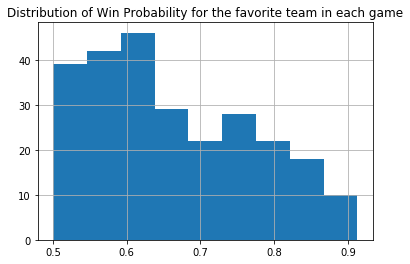

In [4]:
fivethirtyeight_forecast[['qbelo_prob1', 'qbelo_prob2']].max(axis=1).hist(bins='auto');
plt.title("Distribution of Win Probability for the favorite team in each game");

In [5]:
# We want a dataframe where each row is week-team (so two rows per match -- one for each team)
expanded_df = pd.concat([
    fivethirtyeight_forecast[['week_id', 'team1', 'qbelo_prob1']].rename(columns={'week_id': 'week',
                                                                                  'team1': 'team',
                                                                                  'qbelo_prob1': 'win_prob'}),
    fivethirtyeight_forecast[['week_id', 'team2', 'qbelo_prob2']].rename(columns={'week_id': 'week',
                                                                                  'team2': 'team',
                                                                                  'qbelo_prob2': 'win_prob'}),
])
expanded_df.sort_values('week', inplace=True)
assert len(expanded_df) == 256 * 2
uniq_teams = expanded_df["team"].unique()
n_weeks = expanded_df['week'].max()

In [6]:
expanded_df.head()

,week,team,win_prob
0,1,CHI,0.640182
12,1,DET,0.510370
11,1,NYG,0.257070
10,1,SF,0.454431
9,1,CIN,0.246160


# Strategy 1: Greedy

Given win probabiltiies for each matchup, each week the strategy is just to pick the team with the highest probability of winning for that week, excluding any teams that have been picked in previous weeks.

In [7]:
def make_greedy_picks(df, n_weeks=n_weeks):
    picks = []
    win_probs = []
    for week in range(1, n_weeks + 1):
        week_matches = df[df["week"] == week].copy()     
        selection = (week_matches[~week_matches["team"].isin(picks)]
                     .sort_values("win_prob", ascending=False)
                     .iloc[0])
        picks.append(selection['team'])
        win_probs.append(selection['win_prob'])
    return picks, win_probs

In [8]:
greedy_picks, win_probs = make_greedy_picks(expanded_df)
assert len(greedy_picks) == len(np.unique(greedy_picks)) == expanded_df['week'].max()

In [9]:
greedy_picks_df = pd.DataFrame({'week': np.arange(1, n_weeks + 1),
                          'pick': greedy_picks,
                          'win_prob': win_probs})
greedy_picks_df['prob_surviving'] = greedy_picks_df['win_prob'].cumprod()

Here are the results for the greedy algorithm

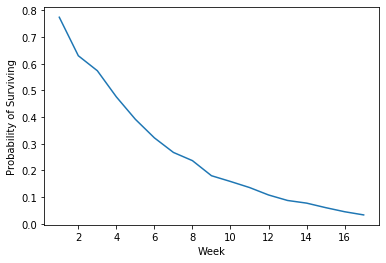

In [10]:
plt.plot(greedy_picks_df['week'], greedy_picks_df['prob_surviving'])
plt.xlabel("Week")
plt.ylabel("Probability of Surviving");

In [11]:
greedy_picks_df

,week,pick,win_prob,prob_surviving
0,1,PHI,0.774390,0.774390
1,2,NE,0.813639,0.630073
2,3,DAL,0.910799,0.573870
3,4,LAR,0.829112,0.475803
4,5,KC,0.823315,0.391736
5,6,BAL,0.822380,0.322156
6,7,BUF,0.830516,0.267555
7,8,MIN,0.884924,0.236766
8,9,SEA,0.761350,0.180262
9,10,NO,0.880208,0.158668


# Strategy 2: Constrained Optimization

So the greedy heuristic does OK, but can we do better using fancy math? Let's find out! We can pose our setup as a constrained optimization problem. Specifically, this is a [Integer Programming](https://en.wikipedia.org/wiki/Integer_programming) problem.

Define $S \in \{0, 1\}^{W \times T}$ to be an indicator matrix for our picks, where $S_{w,t} = 1$ if we picked team $t$ to win in week $w$, and 0 otherwise.

$\mathrm{winprob}_{w,t}$ is the given probability of team $t$ winning in the game that they're playing in week $w$.

Our optimization problem is then:

\begin{align}
& \max & & \prod_w \sum_t S_{w,t} \mathrm{winprob}_{w,t} \\
& \textrm{such that} & & \sum_t S_{w,t} = 1 \; \forall \; w\\
&               & & \sum_w S_{w,t} \le 1 \; \forall \; t 
\end{align}

In words, what we're saying is that the probability of surviving to the end is equal to the product of the probability of winning each week (even one loss and we're out, so we need to win each week). We want to make picks that maximize this product, subject to the following two constraints:
- we have to pick exactly one team each week
- we can pick each team at most 1 time

(To make the math and code slightly easier, we're actually going to take the log of $\mathrm{winprob}$ and convert the objective function from a product to a sum)

To do this optimization, we turn to the Python package `pyomo` (using the GNU Linear Programming Kit under the hood). I was previously unfamiliar with this package, but found this excellent tutorial from Stitchfix [here](https://multithreaded.stitchfix.com/blog/2018/06/21/constrained-optimization/). What follows is a relatively straightforward adaptation of the code presented in that post. Rather than parrot the `pyomo` explanations in that post, I'll refer you there for any questions about the functions. I was somewhat surprised at how much I was able to treat `pyomo` as a black box. I didn't have to specify the appropriate algorithm for binary integer programming as opposed to linear programming, it just figured it out.

In [12]:
expanded_df['log_win_prob'] = np.log(expanded_df['win_prob'])
week_team_winprob = expanded_df.set_index(['week', 'team'])['log_win_prob'].to_dict()

In [13]:
# Not every team plays every week. The simplest way it seemed for me to tell
# the optimizer not to make a pick like that was to fill in the gaps with very low win-probability.
# If the optimizer picks that team to win that week, we've got a problem
for week in expanded_df['week'].unique():
    for team in expanded_df['team'].unique():
        if (week, team) not in week_team_winprob:
            week_team_winprob[(week, team)] = -1e9

In [14]:
model = pe.ConcreteModel()

model.weeks = pe.Set(initialize=expanded_df['week'].unique().tolist())
model.teams = pe.Set(initialize=expanded_df['team'].unique().tolist())

# Take win probabilities as a given
model.win_probabilities = pe.Param(model.weeks * model.teams,
                                   default=week_team_winprob)

# This is the parameter we're optimizing
model.picks = pe.Var(model.weeks * model.teams,
                    domain=pe.Binary)

# Our objective function
model.objective = pe.Objective(
    expr=pe.summation(model.win_probabilities, model.picks),
    sense=pe.maximize)

In [15]:
# Add constraints
def one_team_per_week(model, week):
    n_teams_per_week = sum(model.picks[week, team] for team in model.teams)
    return n_teams_per_week == 1

model.one_team_per_week = pe.Constraint(model.weeks, rule=one_team_per_week)

def cant_pick_team_twice(model, team):
    n_picks_per_team = sum(model.picks[week, team] for week in model.weeks)
    return n_picks_per_team <= 1

model.cant_pick_team_twice = pe.Constraint(model.teams, rule=cant_pick_team_twice)


In [16]:
# Solve
solver = pe.SolverFactory("glpk")
solution = solver.solve(model)

# Comparison and Conclusion

In [17]:
optimal_picks_df = pd.DataFrame(columns=['week', 'pick', 'win_prob'])
for (week, team), picked in model.picks.get_values().items():
    if picked:
        optimal_picks_df = optimal_picks_df.append({'week': week,
                                    'pick': team,
                                    'win_prob': np.exp(week_team_winprob[(week, team)])}, ignore_index=True)
optimal_picks_df['prob_surviving'] = optimal_picks_df['win_prob'].cumprod()


In [18]:
comparison_df = pd.merge(greedy_picks_df[['week', 'pick', 'prob_surviving']],
                         optimal_picks_df[['week', 'pick', 'prob_surviving']],
                         on='week',
                         suffixes=('_greedy', '_optimal'))

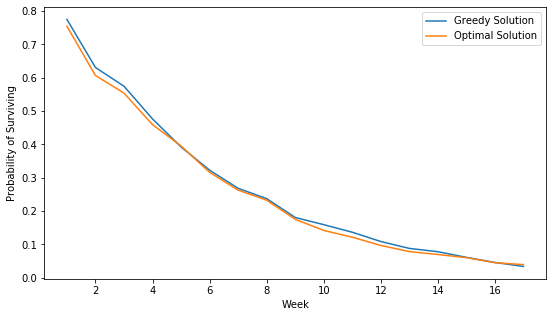

In [19]:
plt.figure(figsize=(9, 5))
plt.plot(greedy_picks_df['week'], greedy_picks_df['prob_surviving'], label="Greedy Solution")
plt.plot(optimal_picks_df['week'], optimal_picks_df['prob_surviving'], label="Optimal Solution")
plt.xlabel("Week")
plt.ylabel("Probability of Surviving");
plt.legend()

In [20]:
comparison_df

,week,pick_greedy,prob_surviving_greedy,pick_optimal,prob_surviving_optimal
0,1,PHI,0.774390,SEA,0.753840
1,2,NE,0.630073,HOU,0.606103
2,3,DAL,0.573870,NE,0.553267
3,4,LAR,0.475803,LAR,0.458720
4,5,KC,0.391736,PHI,0.394715
5,6,BAL,0.322156,LAC,0.315705
6,7,BUF,0.267555,BUF,0.262198
7,8,MIN,0.236766,MIN,0.232026
8,9,SEA,0.180262,SF,0.174773
9,10,NO,0.158668,CHI,0.141343


We can see in the plot above that there's not a huge difference in survival probability between the two weeks. Examining the table below, we see that they do in fact make different picks, but the probability of surviving just isn't that different. The greedy solution does better for most of the season, but does in fact lose in the end to the IP-solver's optimal strategy. But the difference in surival probability between the two is not really very large (3.9% vs 3.3% of surviving all 17 weeks), which is bad news for all you optimization nerds who were hoping to crush the jocks at your office with simplex methods. Better stick to the traveling salesman problem.